# Bodyfat Percentage Predictor

## What is bodyfat and why is it useful to have knowledge about it ?

Bodyfat is the `total amount of fat` in your body. Everybody has at least a little bit of bodyfat.\
It is the extra, stored energy in your body. It's like a savings account for calories. Just as you put money in a savings account to use when you need it, your body stores calories as fat to use for energy later. Having some body fat is normal and healthy, but too much can cause health issues (contrarely to money in your bank account).

Thus, predicting bodyfat percentage can be useful for many reasons, including :
| Bodyfat knowledge benefits  |                                                                                                                                |
|----------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| health               | Knowing the body fat percentage can help us to identify any potential health risks associated with excess body fat.                  |
| athletic performance | Knowing the body fat percentage can help us to stay motivated to lose weight and improve the health as we see the number dicreasing. |
| self-image           | Body fat can affect the athletic performance in a number of ways.                                                                    |
| motivation           | Knowing the body fat percentage can help us to feel more confident and comfortable in the own skin.                                  |

## Purpose of the Notebook

Predicting bodyfat percentage is a `regression problem` as we want to predict a number (the bodyfat percentage of a person) among an infinity of numbers.

This notebook aims to use regression techniques to predict the bodyfat percentage given certain parameters that should be pretty easy to measure for any body.

- Age (years)
- Weight (lbs)
- Height (inches)
- Neck circumference (cm)
- Chest circumference (cm)
- Abdomen 2 circumference (cm)
- Hip circumference (cm)
- Thigh circumference (cm)
- Knee circumference (cm)
- Ankle circumference (cm)
- Biceps (extended) circumference (cm)
- Forearm circumference (cm)
- Wrist circumference (cm)


### 1. Exploratory Data Analysis (EDA) & Cleaning

In [2035]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [1141]:
df = pd.read_csv('data/bodyfat.csv')
df

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


As we can see, our data consists of 252 examples described by 15 features each, with gives us 3,780 values.

Let's check if the dataset is full, or if there are empty entries among the columns.

In [1142]:
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

Density is used to compute the bodyfat according to Siri's formula. We can verify this by plotting scatterpoints between Density and Bodyfat As it is hard to measure without fancy tools, why not try to predict the Density with our models, and then compute bodyfat according to Siri's formula ? We want the model to be easely usable by anybody, so if the user gives only its mensurations, it will be easy an easy and handy AI tool to use.

<Axes: xlabel='Density', ylabel='BodyFat'>

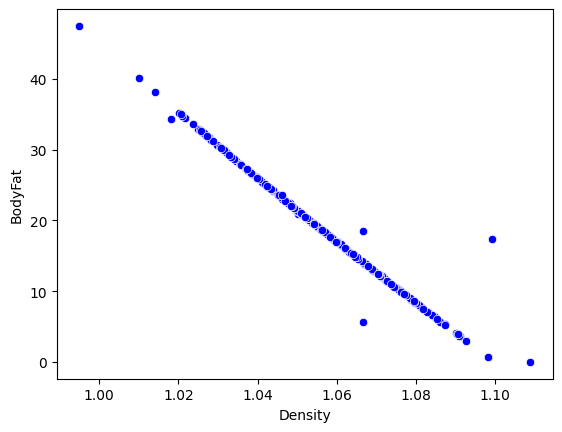

In [1143]:
sns.scatterplot(x=df['Density'], y=df['BodyFat'], color='blue', markers='o')

As we can see, the more a someone has a dense body, the less fat he is. However, it seems like we have some outliers, which shouldn't be there because of the direct correlation Density and Bodyfat Should have (in this dataset the bodyfat is computed thanks to Siri's formula, which uses Density to compute bodyfat). Let's take a closer look.

In [1144]:
#Let's copy the dataframe and drop features other than Density, BodyFat and calculated_bodyfat for better readability
df_copy = df.copy()
df_copy.drop(columns=['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist'], inplace=True)

#Now, let's check which examples are not logical compared to Siri's equation.

df_copy['calculated_bodyfat'] = (4.95 / df_copy['Density'] - 4.5) * 100
# threshold is 0.1 in case bodyfat are rounded
mismatched_examples = df_copy[abs(df_copy['calculated_bodyfat'] - df_copy['BodyFat']) > 0.1]


mismatched_examples

,Density,BodyFat,calculated_bodyfat
5,1.0502,20.9,21.338793
47,1.0665,5.6,14.135021
70,1.0439,24.3,24.183351
75,1.0666,18.5,14.091506
95,1.0991,17.4,0.368483
138,1.0481,22.4,22.283179
168,1.0180,34.3,36.247544
181,1.1089,0.0,-3.611687
199,1.0462,23.6,23.140891


As we can see, According to Siri's formula, we have 9 examples that shouldn't be in the dataset. 

Moreover, someone with 0.0% bodyfat couldn't be alive (example 181).\
It is the same with someone with 1.0991 density (example 95).

These might have been introduced because of typos. To be sure, we will remove these examples from our dataset.



In [1145]:
df_clean = df.copy()
mismatched_indices = mismatched_examples.index
df_clean = df_clean.drop(mismatched_indices)
df_clean

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


<Axes: xlabel='Density', ylabel='BodyFat'>

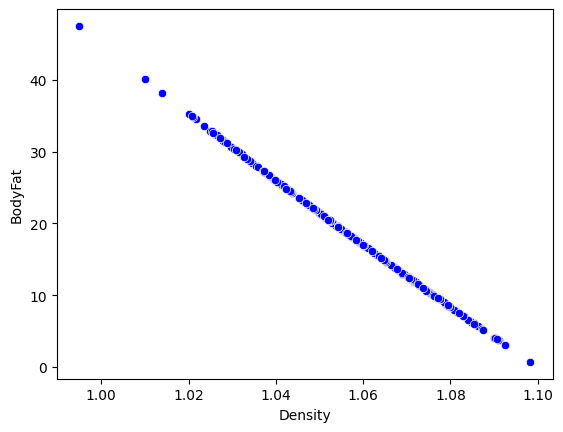

In [1146]:
sns.scatterplot(x=df_clean['Density'], y=df_clean['BodyFat'], color='blue', markers='o')

Now that the Density data is clean, we can check all the features to spot any other outliers and see if they deserve to be in the dataset or not.

Text(0.5, 0.98, 'Data Distribution and Box plots')

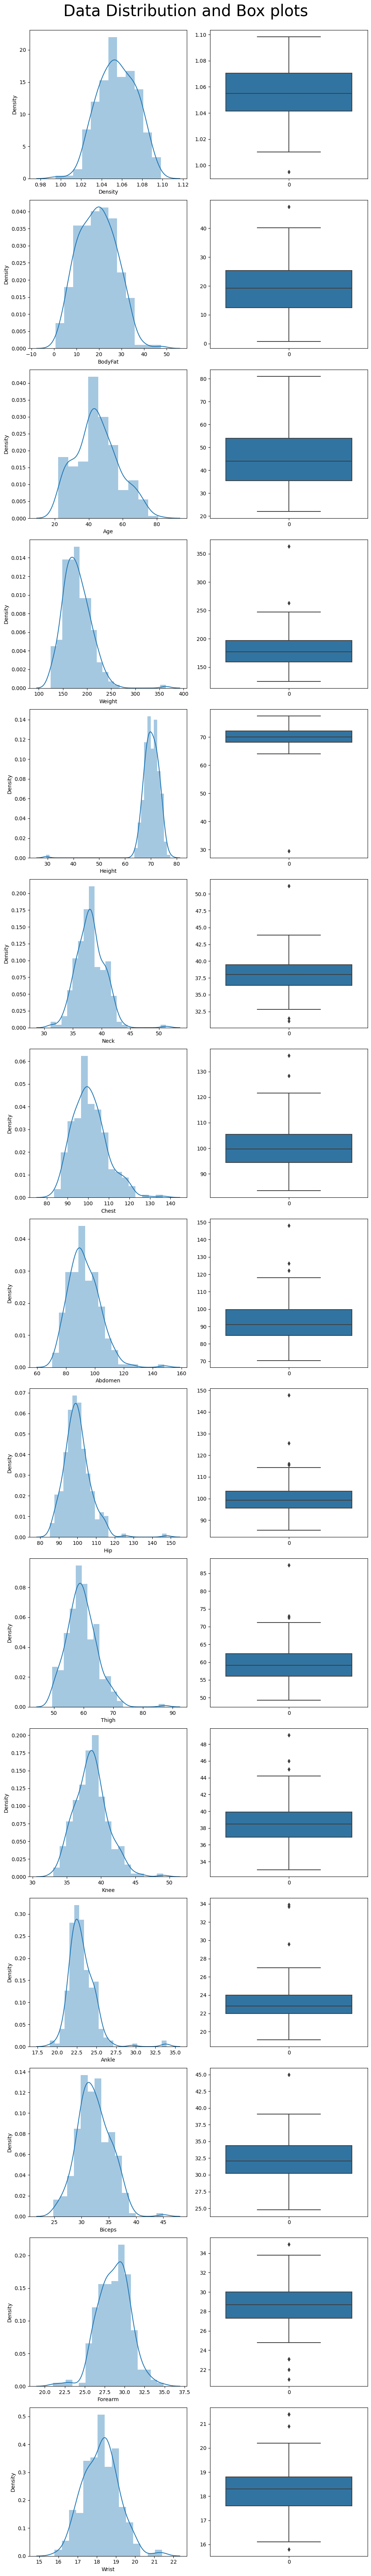

In [1147]:
warnings.filterwarnings('ignore')
plt.close('all')
fig,ax = plt.subplots(15,2,figsize=(10,70))
for index,i in enumerate(df_clean.columns):
    sns.distplot(df_clean[i],ax=ax[index,0])
    sns.boxplot(df_clean[i],ax=ax[index,1])
    
fig.tight_layout()
fig.subplots_adjust(top=0.97)
plt.suptitle("Data Distribution and Box plots",fontsize=30)

As we can see, there are outliers and some feature are skewed. Let's analyse weird numbers, just to check if they are realistic.

In [1148]:
df_clean[df_clean['BodyFat'] > 45]

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
215,0.995,47.5,51,219.0,64.0,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


Someone this 64 inches tall and weighting 219 lbs might have a bodyfat of 47.5

In [1149]:
df_clean[df_clean['Weight'] > 350]

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
38,1.0202,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4


Someone this tall and weighting 363.15kgs seems like a big number, but maybe it is an exception, such as someone obese that may have a disease.

In [1150]:
df_clean[df_clean['Height'] < 35]

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
41,1.025,32.9,44,205.0,29.5,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


This one seems weird. In fact nobody is 29.5 inches tall at 44. Moreover, this person coulnd't weight 205 lbs at this height. I think we can delete this entry without comprometting the data.

In [1151]:
df_clean[df_clean['Hip'] > 120]

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
38,1.0202,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
40,1.0217,34.5,45,262.75,68.75,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4


These two seem realistic.

Now that we double checked inhabitual values, let's drop the 30 inches example.

In [1152]:
df_clean.drop(df_clean[df_clean['Height'] < 35].index)

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


Now that our data seems clean, let's check the correlation matrix to see if there are strong correlation between the target and the individual features.

<Axes: >

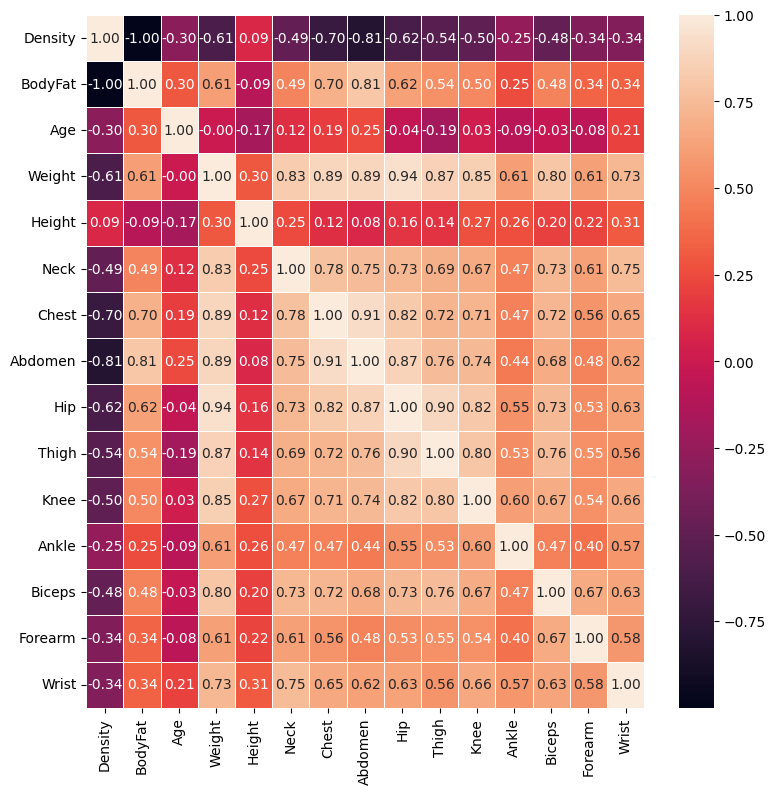

In [1153]:
plt.figure(figsize=(9,9))
sns.heatmap(df_clean.corr(),annot=True,linewidth=0.5,fmt="0.2f")

As we can see, there is some correlation with the target variable : 
- Poor correlation : Height, Ankle
- Moderate correlation : Age, Neck, Biceps, Forearm, Wrist
- Strong correlation : Weight, Chest, Abdomen, Hip, Thigh, Knee

There seem to be multicolinearity. For example, weight is strongly correlated with every other feature, excepted Age and height

### 2. Data Preprocessing & Model building + test with "raw" features

For our tests, we will use KFold cross-validation to make sure we are not overfitting a train or test set. We will also scale the dataset.

In [1154]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_clean.drop(['BodyFat', 'Density'],axis=1)
y = df_clean['Density']

scaler = StandardScaler()

In [1155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1156]:
X_train_scaled = scaler.fit_transform(X_train)

In [1157]:
sgd = SGDRegressor(random_state=42)
lr = LinearRegression()
xgb = XGBRegressor()
rf = RandomForestRegressor(random_state=42)
ridge = Ridge(random_state=42)

regs = {"sgd":sgd, "lr":lr, "xgb":xgb, "rf":rf, "ridge": ridge}

In [1158]:
def evaluate(reg_name, reg, X, y):
    fold = 0
    r2s = []
    rmses = []
    maes = []
    result = []
    for train_i, val_i in kf.split(X):
        X_train = X[train_i]
        y_train = y.iloc[train_i]

        X_val = X[val_i]
        y_val = y.iloc[val_i]

        # Fit model on Train
        reg.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = reg.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        rmses.append(rmse)
        r2s.append(r2)
        maes.append(mae)
        print(f"====== Fold {fold} model {reg_name}======")
        print(f"r2 validation score : {r2} | RMSE validation : {rmse}")
        fold += 1
    
    result = f"====={reg_name} : r2 mean = {np.mean(r2s)} | RMSE mean = {np.mean(rmses)} | MAE mean = {np.mean(maes)}====="
    return result

In [1159]:
def evaluate_all_regs(regs, X, y):
    results = []
    for reg in regs:
        results.append(evaluate(reg, regs[reg], X=X, y=y))

    print(f"==============================")
    for result in results:
        print(result)

In [1160]:
evaluate_all_regs(regs, X_train_scaled, y_train)

====== Fold 0 model sgd======
r2 validation score : -4.980686712372622 | RMSE validation : 0.043947728150731454
====== Fold 1 model sgd======
r2 validation score : -8.793999782395442 | RMSE validation : 0.06414975894465598
====== Fold 2 model sgd======
r2 validation score : -0.6258957968941525 | RMSE validation : 0.025242113142871798
====== Fold 3 model sgd======
r2 validation score : -0.6190521822076089 | RMSE validation : 0.021182055850246507
====== Fold 4 model sgd======
r2 validation score : -1.7468881199946775 | RMSE validation : 0.025935113523709072
====== Fold 0 model lr======
r2 validation score : 0.5724681239184652 | RMSE validation : 0.01175019713955169
====== Fold 1 model lr======
r2 validation score : 0.6909437186932301 | RMSE validation : 0.011395510118666054
====== Fold 2 model lr======
r2 validation score : 0.71590710340771 | RMSE validation : 0.0105513867583935
====== Fold 3 model lr======
r2 validation score : 0.6013111709231244 | RMSE validation : 0.01051125856251326


As we can see, the best results we have with raw features is with Ridge, with a r2 score of 0.682 and a RMSE of 0.011

### 3. Feature engineering

As we saw with the confusion matrix, it seems that we have some multicolinearity between our individual features. Let's do some feature engineering to reduce this multicolinearity with hope to improve performances

Something we could try is looking at the corellation matrix and try to combine some features, with logical combinations.\
For example, instead of keeping height and weight separately, we could use BMI to combine these two features in one and keep the information.\
We could also use some intersting ratios such as abodmen chest ratio.

In [2030]:
X_eng = X_train.copy()
y_eng = y_train.copy()

# Indices
# X_eng['Bmi']=703*X_eng['Weight']/(X_eng['Height']*X_eng['Height'])
# X_eng['Conicity'] = X_eng['Abdomen'] / (0.109 * np.sqrt(X_eng['Weight'] / X_eng['Height']))
# X_eng['Corpulence'] = (X_eng['Weight']/2.205) / ((X_eng['Height']/39.37)**3)

# X_eng['ACRatio'] = X_eng['Abdomen']/X_eng['Chest']
# X_eng['AHipRatio'] =  X_eng['Abdomen']/X_eng['Hip']
# X_eng['ATRatio'] = X_eng['Abdomen']/X_eng['Thigh']
X_eng['AAnRatio'] = X_eng['Abdomen']/X_eng['Ankle']
X_eng['AWnRatio'] = X_eng['Abdomen']/X_eng['Wrist']
# X_eng['AKRatio'] = X_eng['Abdomen']/X_eng['Knee']
X_eng['AFRatio'] = X_eng['Abdomen']/X_eng['Forearm']
# X_eng['AHRatio'] = X_eng['Abdomen']/X_eng['Height']
X_eng['AARatio'] = X_eng['Abdomen']/X_eng['Age']
X_eng['WARatio'] = X_eng['Abdomen']/X_eng['Weight']
# X_eng['ABRatio'] = X_eng['Abdomen']/X_eng['Biceps']
# X_eng['ANRatio'] = X_eng['Abdomen']/X_eng['Neck']

# X_eng['HCRatio'] = X_eng['Hip']/X_eng['Chest']
# X_eng['HTRatio'] = X_eng['Hip']/X_eng['Thigh']
# X_eng['HAnRatio'] = X_eng['Hip']/X_eng['Ankle']
# X_eng['HWnRatio'] = X_eng['Hip']/X_eng['Wrist']
# X_eng['HKRatio'] = X_eng['Hip']/X_eng['Knee']
# X_eng['HFRatio'] = X_eng['Hip']/X_eng['Forearm']
# X_eng['HHRatio'] = X_eng['Hip']/X_eng['Height']
# X_eng['HARatio'] = X_eng['Hip']/X_eng['Age']
# X_eng['HARatio'] = X_eng['Hip']/X_eng['Weight']
# X_eng['HBRatio'] = X_eng['Hip']/X_eng['Biceps']
# X_eng['HNRatio'] = X_eng['Hip']/X_eng['Neck']

X_eng['TCRatio'] = X_eng['Thigh']/X_eng['Chest']
# X_eng['TAnRatio'] = X_eng['Thigh']/X_eng['Ankle']
X_eng['TWnRatio'] = X_eng['Thigh']/X_eng['Wrist']
# X_eng['TKRatio'] = X_eng['Thigh']/X_eng['Knee']
# X_eng['TFRatio'] = X_eng['Thigh']/X_eng['Forearm']
# X_eng['THRatio'] = X_eng['Thigh']/X_eng['Height']
X_eng['TARatio'] = X_eng['Thigh']/X_eng['Age']
# X_eng['TARatio'] = X_eng['Thigh']/X_eng['Weight']
# X_eng['TBRatio'] = X_eng['Thigh']/X_eng['Biceps']
# X_eng['TNRatio'] = X_eng['Thigh']/X_eng['Neck']

# X_eng['CAnRatio'] = X_eng['Chest']/X_eng['Ankle']
X_eng['CWnRatio'] = X_eng['Chest']/X_eng['Wrist']
X_eng['CKRatio'] = X_eng['Chest']/X_eng['Knee']
# X_eng['CFRatio'] = X_eng['Chest']/X_eng['Forearm']
# X_eng['CHRatio'] = X_eng['Chest']/X_eng['Height']
# X_eng['CARatio'] = X_eng['Chest']/X_eng['Age']
# X_eng['CARatio'] = X_eng['Chest']/X_eng['Weight']
# X_eng['CBRatio'] = X_eng['Chest']/X_eng['Biceps']
# X_eng['CNRatio'] = X_eng['Chest']/X_eng['Neck']

# X_eng['ANWnRatio'] = X_eng['Ankle']/X_eng['Wrist']
# X_eng['ANKRatio'] = X_eng['Ankle']/X_eng['Knee']
# X_eng['ANFRatio'] = X_eng['Ankle']/X_eng['Forearm']
# X_eng['ANHRatio'] = X_eng['Ankle']/X_eng['Height']
# X_eng['ANARatio'] = X_eng['Ankle']/X_eng['Age']
# X_eng['ANARatio'] = X_eng['Ankle']/X_eng['Weight']
# X_eng['ANBRatio'] = X_eng['Ankle']/X_eng['Biceps'] # A ESSAYER DE VIRER
X_eng['ANNRatio'] = X_eng['Ankle']/X_eng['Neck']

# X_eng['WKRatio'] = X_eng['Wrist']/X_eng['Knee']
# X_eng['WFRatio'] = X_eng['Wrist']/X_eng['Forearm']
# X_eng['WHRatio'] = X_eng['Wrist']/X_eng['Height']
# X_eng['WARatio'] = X_eng['Wrist']/X_eng['Age']
# X_eng['WARatio'] = X_eng['Wrist']/X_eng['Weight']
X_eng['WBRatio'] = X_eng['Wrist']/X_eng['Biceps']
# X_eng['WNRatio'] = X_eng['Wrist']/X_eng['Neck']


# X_eng['KFRatio'] = X_eng['Knee']/X_eng['Forearm']
# X_eng['KHRatio'] = X_eng['Knee']/X_eng['Height']
# X_eng['KARatio'] = X_eng['Knee']/X_eng['Age']
# X_eng['KARatio'] = X_eng['Knee']/X_eng['Weight']
# X_eng['KBRatio'] = X_eng['Knee']/X_eng['Biceps']
# X_eng['KNRatio'] = X_eng['Knee']/X_eng['Neck']
# X_eng['FHRatio'] = X_eng['Forearm']/X_eng['Height']
# X_eng['FARatio'] = X_eng['Forearm']/X_eng['Age']

# X_eng['FARatio'] = X_eng['Forearm']/X_eng['Weight']
# X_eng['FBRatio'] = X_eng['Forearm']/X_eng['Biceps']
# X_eng['FNRatio'] = X_eng['Forearm']/X_eng['Neck']

# X_eng['HEARatio'] = X_eng['Height']/X_eng['Age']
# X_eng['HEARatio'] = X_eng['Height']/X_eng['Weight']
# X_eng['HEBRatio'] = X_eng['Height']/X_eng['Biceps']
# X_eng['HENRatio'] = X_eng['Height']/X_eng['Neck']

# X_eng['AGARatio'] = X_eng['Age']/X_eng['Weight']

X_eng['AGBRatio'] = X_eng['Age']/X_eng['Biceps']
# X_eng['AGNRatio'] = X_eng['Age']/X_eng['Neck']
# X_eng['WEBRatio'] = X_eng['Weight']/X_eng['Biceps']
# X_eng['WENRatio'] = X_eng['Weight']/X_eng['Neck']

# X_eng['BNRatio'] = X_eng['Biceps']/X_eng['Neck']


# Products
# X_eng['ACProduct'] = X_eng['Abdomen'] * X_eng['Chest']
# X_eng['AHProduct'] = X_eng['Abdomen'] * X_eng['Hip']

# Differences
# X_eng['ACDifference'] = X_eng['Abdomen'] - X_eng['Chest']
# X_eng['ACDifference'] = X_eng['Abdomen'] - X_eng['Hip']
# X_eng['ACDifference'] = X_eng['Abdomen'] - X_eng['Thigh']



# Dropping non pertinent features
X_eng.drop(['Abdomen', 'Hip', 'Ankle', 'Wrist', 'Knee'],axis=1,inplace=True)
X_eng.head()

,Age,Weight,Height,Neck,Chest,Thigh,Biceps,Forearm,AAnRatio,AWnRatio,...,AARatio,WARatio,TCRatio,TWnRatio,TARatio,CWnRatio,CKRatio,ANNRatio,WBRatio,AGBRatio
120,52,206.50,74.50,40.8,104.3,58.5,33.9,31.2,4.032520,5.087179,...,1.907692,0.480387,0.560882,3.000000,1.125000,5.348718,2.653944,0.602941,0.575221,1.533923
216,51,149.25,69.75,34.8,92.8,53.8,31.3,26.3,3.772093,4.556180,...,1.590196,0.543384,0.579741,3.022472,1.054902,5.213483,2.542466,0.617816,0.568690,1.629393
164,34,218.75,72.00,39.5,111.4,63.8,34.0,31.2,4.529915,5.729730,...,3.117647,0.484571,0.572711,3.448649,1.876471,6.021622,2.652381,0.592405,0.544118,1.000000
137,43,187.75,74.00,37.7,97.8,63.6,34.3,28.4,4.142857,5.570621,...,2.293023,0.525166,0.650307,3.593220,1.479070,5.525424,2.494898,0.631300,0.516035,1.253644
88,46,176.75,72.50,38.0,97.3,61.0,30.2,29.3,3.613445,4.574468,...,1.869565,0.486563,0.626927,3.244681,1.326087,5.175532,2.533854,0.626316,0.622517,1.523179


In [2031]:
X_eng_scaled = scaler.fit_transform(X_eng)

In [2032]:
evaluate_all_regs(regs, X_eng_scaled, y_eng)

====== Fold 0 model sgd======
r2 validation score : -4.729825698355363 | RMSE validation : 0.043016156968529
====== Fold 1 model sgd======
r2 validation score : -10.825784628259585 | RMSE validation : 0.07049039860897173
====== Fold 2 model sgd======
r2 validation score : -0.7479662933816629 | RMSE validation : 0.026172540573240862
====== Fold 3 model sgd======
r2 validation score : -0.7996995102119477 | RMSE validation : 0.0223325175969103
====== Fold 4 model sgd======
r2 validation score : -2.2407747942591723 | RMSE validation : 0.028170340342450025
====== Fold 0 model lr======
r2 validation score : 0.7011811279310921 | RMSE validation : 0.009823469788595496
====== Fold 1 model lr======
r2 validation score : 0.7125243122478351 | RMSE validation : 0.010990451765269022
====== Fold 2 model lr======
r2 validation score : 0.7663789976399747 | RMSE validation : 0.00956831129832068
====== Fold 3 model lr======
r2 validation score : 0.5949320953974842 | RMSE validation : 0.0105950156446322
=

As we can see, sgd is not a good model for our problem. We will focus en Linear Regression, XGBoost, RandomForest and Ridge.

Let's try a grid search for XGBoost, RandomForest and Ridge

### 4. Grid Search

First let's define a function for our grid search.

In [2058]:
def grid_search_launcher(reg, param_grid, cv, X, y):
    grid_search = GridSearchCV(reg, param_grid, cv=cv)

    grid_search.fit(X, y)

    print("Best score:", grid_search.best_score_)
    print("Best hyperparamters:", grid_search.best_params_)
    

#### 4.1 Ridge

In [2059]:
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0]    
}

grid_search_launcher(regs['ridge'], param_grid_ridge, 5, X_eng_scaled, y_eng)

Best score: 0.6814601600530992
Best hyperparamters: {'alpha': 0.1}


#### 4.2 XGBRegressor

In [2049]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],             # Nombre d'arbres
    'learning_rate': [0.01, 0.1, 0.2],          # Taux d'apprentissage
    'max_depth': [None, 3, 4, 5, 10, 20],                     # Profondeur maximale de l'arbre
    'subsample': [0.8, 1.0],                    # Sous-échantillonnage des données d'entraînement
}

grid_search_launcher(regs['xgb'], param_grid_xgb, 5, X_eng_scaled, y_eng)

Best score: 0.6667090636302054
Best hyperparamters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


#### 4.3 RFRegressor

In [2050]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],          # Nombre d'arbres dans la forêt
    'max_depth': [None, 5, 10, 20],             # Profondeur maximale de chaque arbre
    'min_samples_split': [2, 5, 10],         # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]            # Nombre minimum d'échantillons requis pour être une feuille
}

grid_search_launcher(regs['rf'], param_grid_rf, 5, X_eng_scaled, y_eng)


Best score: 0.6723011451534118
Best hyperparamters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


As we can see, even with grid search, The Standard linear regression model seems to be better than other types of regressors. Let's test them all one last time with their optimized parameters on the test set.

### 5. Testing Optimized model on the test set

Let's create the same features we created with the X_eng set on the test set. We will call it X_test_eng

In [2052]:
X_test_eng = X_test.copy()
y_test_eng = y_test.copy()

X_test_eng['AAnRatio'] = X_test_eng['Abdomen']/X_test_eng['Ankle']
X_test_eng['AWnRatio'] = X_test_eng['Abdomen']/X_test_eng['Wrist']
X_test_eng['AFRatio'] = X_test_eng['Abdomen']/X_test_eng['Forearm']
X_test_eng['AARatio'] = X_test_eng['Abdomen']/X_test_eng['Age']
X_test_eng['WARatio'] = X_test_eng['Abdomen']/X_test_eng['Weight']


X_test_eng['TCRatio'] = X_test_eng['Thigh']/X_test_eng['Chest']
X_test_eng['TWnRatio'] = X_test_eng['Thigh']/X_test_eng['Wrist']
X_test_eng['TARatio'] = X_test_eng['Thigh']/X_test_eng['Age']

X_test_eng['CWnRatio'] = X_test_eng['Chest']/X_test_eng['Wrist']
X_test_eng['CKRatio'] = X_test_eng['Chest']/X_test_eng['Knee']

X_test_eng['ANNRatio'] = X_test_eng['Ankle']/X_test_eng['Neck']

X_test_eng['WBRatio'] = X_test_eng['Wrist']/X_test_eng['Biceps']

X_test_eng['AGBRatio'] = X_test_eng['Age']/X_test_eng['Biceps']

X_test_eng.drop(['Abdomen', 'Hip', 'Ankle', 'Wrist', 'Knee'],axis=1,inplace=True)

X_test_eng.head()

,Age,Weight,Height,Neck,Chest,Thigh,Biceps,Forearm,AAnRatio,AWnRatio,...,AARatio,WARatio,TCRatio,TWnRatio,TARatio,CWnRatio,CKRatio,ANNRatio,WBRatio,AGBRatio
25,27,159.25,71.50,35.7,89.6,55.0,29.9,28.2,3.542222,4.502825,...,2.951852,0.500471,0.613839,3.107345,2.037037,5.062147,2.441417,0.630252,0.591973,0.903010
7,25,176.00,72.50,37.8,99.6,60.0,30.5,29.0,3.814655,4.707447,...,3.540000,0.502841,0.602410,3.191489,2.400000,5.297872,2.527919,0.613757,0.616393,0.819672
158,30,136.50,68.75,35.9,88.7,50.1,27.0,34.9,3.513761,4.532544,...,2.553333,0.561172,0.564825,2.964497,1.670000,5.248521,2.548851,0.607242,0.625926,1.111111
241,65,224.50,68.25,38.8,119.6,61.3,34.9,30.1,5.042735,6.082474,...,1.815385,0.525612,0.512542,3.159794,0.943077,6.164948,2.840855,0.603093,0.555874,1.862464
247,70,134.25,67.00,34.9,89.2,49.6,25.6,25.7,3.888372,4.518919,...,1.194286,0.622719,0.556054,2.681081,0.708571,4.821622,2.563218,0.616046,0.722656,2.734375


In [2055]:
X_test_eng_scaled = scaler.transform(X_test_eng)

Now let's create Our models with optimized parameters.

In [2060]:
lr_opt = LinearRegression()
ridge_opt = Ridge(alpha=0.1, random_state=42)
xgb_opt = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, subsample = 0.8)
rf_opt = RandomForestRegressor(n_estimators= 50, max_depth= 10, min_samples_leaf=1, min_samples_split=2, random_state=42)

regs_optimized = {"lr": lr_opt, "ridge": ridge_opt, "xgb": xgb_opt, "rf":rf_opt}

First let's test them one more time with our evaluate method on X_eng_scaled, y_eng

In [2061]:
evaluate_all_regs(regs_optimized, X_eng_scaled, y_eng)

====== Fold 0 model lr======
r2 validation score : 0.7011811279310921 | RMSE validation : 0.009823469788595496
====== Fold 1 model lr======
r2 validation score : 0.7125243122478351 | RMSE validation : 0.010990451765269022
====== Fold 2 model lr======
r2 validation score : 0.7663789976399747 | RMSE validation : 0.00956831129832068
====== Fold 3 model lr======
r2 validation score : 0.5949320953974842 | RMSE validation : 0.0105950156446322
====== Fold 4 model lr======
r2 validation score : 0.6396172824741652 | RMSE validation : 0.009393980313266959
====== Fold 0 model ridge======
r2 validation score : 0.6939638925626961 | RMSE validation : 0.009941392884677472
====== Fold 1 model ridge======
r2 validation score : 0.7278138258043676 | RMSE validation : 0.010694192920208952
====== Fold 2 model ridge======
r2 validation score : 0.7614660304257987 | RMSE validation : 0.00966839694908919
====== Fold 3 model ridge======
r2 validation score : 0.5846751518451854 | RMSE validation : 0.010728318125

As we can see our results are a bit different with gridsearchCV, Ridge is the best. Now let's test our parameters on the test_set

In [2062]:
def evaluate_test(reg_name, reg, X, y):
    y_pred = reg.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)


    result = f"====={reg_name} : r2  = {np.mean(r2)} | RMSE  = {np.mean(rmse)} | MAE  = {np.mean(mae)}====="
    return result

In [2064]:
def evaluate_all_regs_test(regs, X, y):
    results = []
    for reg in regs:
        results.append(evaluate_test(reg, regs[reg], X=X, y=y))

    for result in results:
        print(result)

In [2065]:
evaluate_all_regs_test(regs=regs_optimized, X=X_test_eng_scaled, y = y_test_eng)

=====lr : r2  = 0.7097071564349562 | RMSE  = 0.010413526351304516 | MAE  = 0.007944965460709144=====
=====ridge : r2  = 0.7418980692383756 | RMSE  = 0.009819181376793537 | MAE  = 0.007672499191539838=====
=====xgb : r2  = 0.6432216220834241 | RMSE  = 0.011544600769008744 | MAE  = 0.00938563811243796=====
=====rf : r2  = 0.7494471655851731 | RMSE  = 0.00967451752457451 | MAE  = 0.007720423123648426=====


It looks like random forest is best on the test set. However, Ridge is better on kfold cross validation and very close to rf in test set. I assume that ridge will generalize better. Let's test on my mensurations to see the result

In [2157]:
my_mensurations = {
    "Age" : [24],
    "Weight" : [68.5*2.205],
    "Height" : [168/2.54],
    "Abdomen" : [77],
    "Neck" : [35],
    "Chest" : [105],
    "Thigh" : [55],
    "Biceps" : [35],
    "Forearm" : [31],
    "Wrist" : [16.5],
    "Ankle" : [20.5],
    "Knee": [35]
}

Now let's create a method that takes in input one people's mensuration and returns the right input for the model.

In [2158]:
def mens_to_input(mens:dict) -> pd.DataFrame:
    mens_df = pd.DataFrame(mens)

    input = mens_df.copy()

    input['AAnRatio'] = input['Abdomen']/input['Ankle']
    input['AWnRatio'] = input['Abdomen']/input['Wrist']
    input['AFRatio'] = input['Abdomen']/input['Forearm']
    input['AARatio'] = input['Abdomen']/input['Age']
    input['WARatio'] = input['Abdomen']/input['Weight']


    input['TCRatio'] = input['Thigh']/input['Chest']
    input['TWnRatio'] = input['Thigh']/input['Wrist']
    input['TARatio'] = input['Thigh']/input['Age']

    input['CWnRatio'] = input['Chest']/input['Wrist']
    input['CKRatio'] = input['Chest']/input['Knee']

    input['ANNRatio'] = input['Ankle']/input['Neck']

    input['WBRatio'] = input['Wrist']/input['Biceps']

    input['AGBRatio'] = input['Age']/input['Biceps']

    input.drop(['Abdomen', 'Ankle', 'Wrist', 'Knee'],axis=1,inplace=True)

    return input
    


In [2159]:
input = mens_to_input(my_mensurations)

input.columns

Index(['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Thigh', 'Biceps',
       'Forearm', 'AAnRatio', 'AWnRatio', 'AFRatio', 'AARatio', 'WARatio',
       'TCRatio', 'TWnRatio', 'TARatio', 'CWnRatio', 'CKRatio', 'ANNRatio',
       'WBRatio', 'AGBRatio'],
      dtype='object')

In [2160]:
X_test_eng.columns

Index(['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Thigh', 'Biceps',
       'Forearm', 'AAnRatio', 'AWnRatio', 'AFRatio', 'AARatio', 'WARatio',
       'TCRatio', 'TWnRatio', 'TARatio', 'CWnRatio', 'CKRatio', 'ANNRatio',
       'WBRatio', 'AGBRatio'],
      dtype='object')

In [2161]:
input_scaled = scaler.transform(input)

y_pred = regs_optimized['rf'].predict(input_scaled)

y_pred

Siri = (4.95 / y_pred - 4.5) * 100

Siri

array([12.15121588])

In [2162]:
input_scaled = scaler.transform(input)

y_pred = regs_optimized['ridge'].predict(input_scaled)

y_pred

Siri = (4.95 / y_pred - 4.5) * 100

Siri

array([9.71829731])

I estimate myself at around 12% bodyfat, so I would say RandomForest performs better in the general case, as we can see with the test set and my own mensurations.